# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_T0 = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print(data_T0.shape)


(1050, 15)


In [3]:
data_T0.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [4]:
#Ne garder que la base de l'arbre
data_T0['product_category_tree']=data_T0['product_category_tree'].str.split('>>').str[0].str.replace('\[\"','' , regex=True)

In [5]:
data_T0.groupby('product_category_tree')['product_category_tree'].count()

product_category_tree
Baby Care                      150
Beauty and Personal Care       150
Computers                      150
Home Decor & Festive Needs     150
Home Furnishing                150
Kitchen & Dining               150
Watches                        150
Name: product_category_tree, dtype: int64

## Nettoyage du texte

In [6]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def tokenizer_fct(sentence) :

    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


data_T=data_T0

data_T['sentence_bow'] = data_T0['description'].apply(lambda x : transform_bow_fct(x))
data_T['sentence_bow_lem'] = data_T0['description'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T0['description'].apply(lambda x : transform_dl_fct(x))
data_T.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(1050, 18)

In [7]:
data_T.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'sentence_bow',
       'sentence_bow_lem', 'sentence_dl'],
      dtype='object')

In [8]:
#Sauvgarder les données prétraitées dans un nouveau fichier .csv
data_T.to_csv("data_propre.csv")

# Préparation commune des traitements

In [9]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [10]:
data_T =  pd.read_csv("data_propre.csv")
print(data_T.shape)

(1050, 19)


In [11]:
l_cat = list(set(data_T['product_category_tree']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['product_category_tree'])) for i in range(len(data_T))]

catégories :  ['Home Decor & Festive Needs ', 'Beauty and Personal Care ', 'Computers ', 'Kitchen & Dining ', 'Watches ', 'Baby Care ', 'Home Furnishing ']


In [37]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(l_cat)
y_cat_num2 = le.transform(l_cat)


In [12]:
data_T.head(2)

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,sentence_bow,sentence_bow_lem,sentence_dl
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,Baby Care,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...


In [13]:
set(y_cat_num)

{-5, -4, -3, -2, -1, 0, 1}

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  379
max length dl :  632


## Fonctions communes

In [15]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie" ,bbox_to_anchor=(1.05, 1.0))
    plt.title('Représentation des catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters" ,bbox_to_anchor=(1.05, 1.0))
    plt.title('Représentation catégories par clusters')
    plt.tight_layout()
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [16]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

## Exécution des modèles

In [17]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.4206 time :  107.0

Tf-idf : 
--------
ARI :  0.451 time :  118.0


## Graphiques

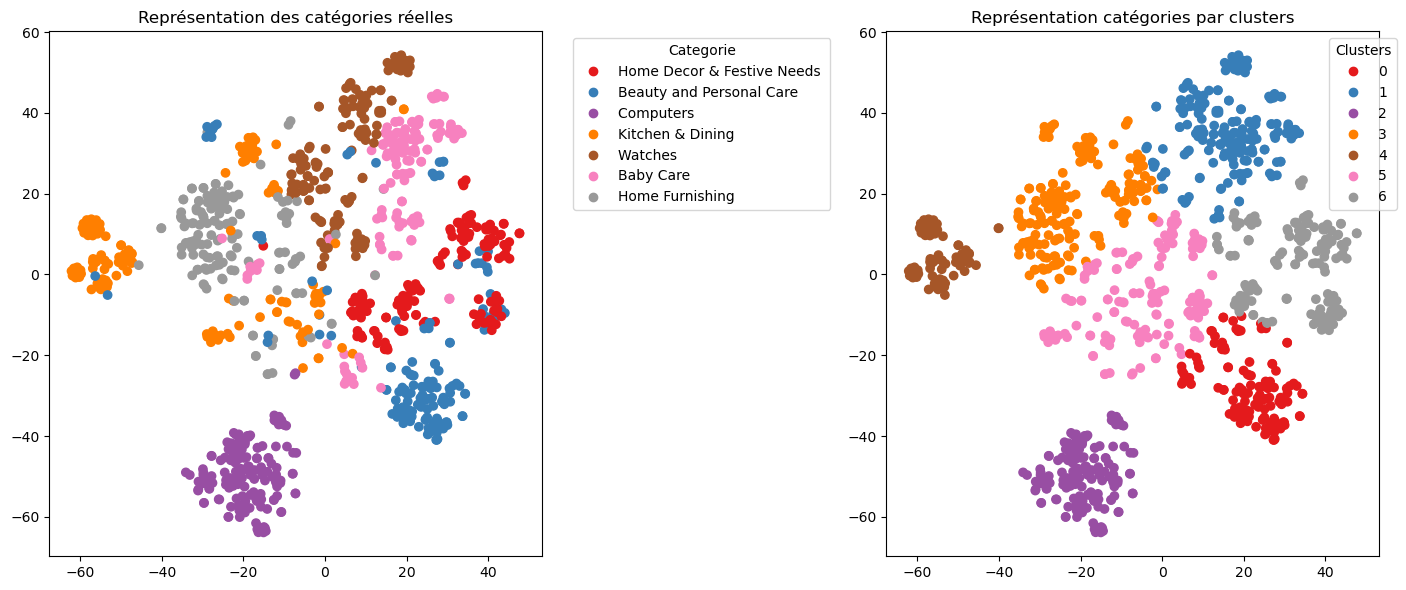

ARI :  0.451


In [18]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [19]:
l_cat

['Home Decor & Festive Needs ',
 'Beauty and Personal Care ',
 'Computers ',
 'Kitchen & Dining ',
 'Watches ',
 'Baby Care ',
 'Home Furnishing ']

In [20]:
X_tsne, y_cat_num, labels, ARI

(array([[  9.541702 ,  -7.7853847],
        [ 40.38376  , -12.557231 ],
        [ 39.093292 , -10.290867 ],
        ...,
        [-26.500698 ,  37.168015 ],
        [-28.100441 ,  35.224514 ],
        [-27.077042 ,  36.769142 ]], dtype=float32),
 [-5,
  -4,
  -4,
  -5,
  -5,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -3,
  -5,
  -5,
  -5,
  1,
  -2,
  -2,
  -5,
  -4,
  -5,
  -4,
  0,
  -2,
  -2,
  -2,
  -1,
  -2,
  0,
  -2,
  -1,
  -2,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -4,
  -2,
  -2,
  -4,
  -5,
  -2,
  -2,
  -2,
  -5,
  -2,
  -4,
  -4,
  -4,
  0,
  0,
  -5,
  -4,
  1,
  1,
  -4,
  -4,
  1,
  1,
  -2,
  -1,
  -5,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  -5,
  -5,
  -5,
  -4,
  -5,
  -5,
  -5,
  -4,
  1,
  -4,
  -2,
  -4,
  -1,
  1,
  -4,
  1,
  -1,
  -5,
  -4,
  -1,
  1,
  0,
  0,
  0,
  0,
  1,
  -2,
  -2,
  -2,
 

In [27]:
ctf_transform

<1050x5324 sparse matrix of type '<class 'numpy.float64'>'
	with 34179 stored elements in Compressed Sparse Row format>

In [42]:
y_cat_num

array([5, 6, 6, ..., 3, 3, 3])

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

conf_mat = confusion_matrix(y_cat_num2, labels)
print(conf_mat)

ValueError: Found input variables with inconsistent numbers of samples: [7, 1050]

In [39]:
y_cat_num2

array([3, 1, 2, 5, 6, 0, 4])

In [ ]:
(y_cat_num, cls.labels_)

# Word2Vec

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1413900   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1413900 (5.39 MB)
Trainable params: 1413900 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Exécution du modèle

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [ ]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2159 time :  13.0


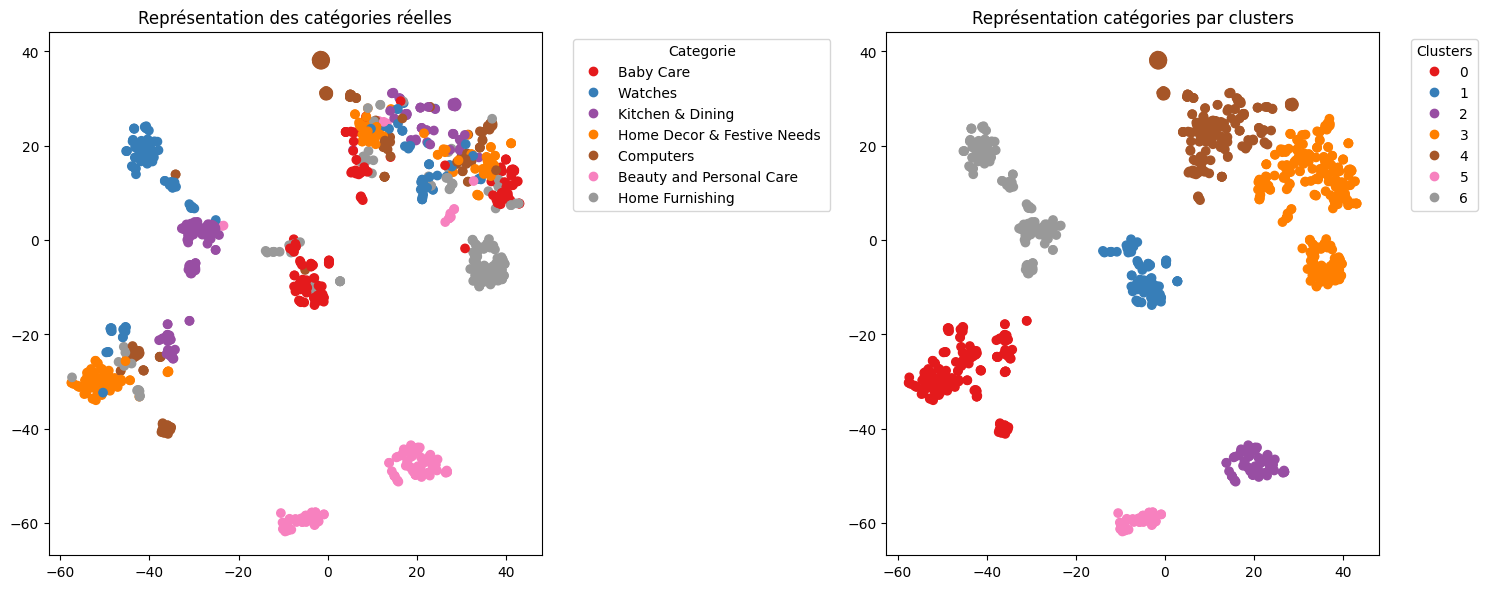

ARI :  0.2159


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
True


## Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1/1 [==============================] - 2s 2s/step
temps traitement :  315.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3203 time :  14.0


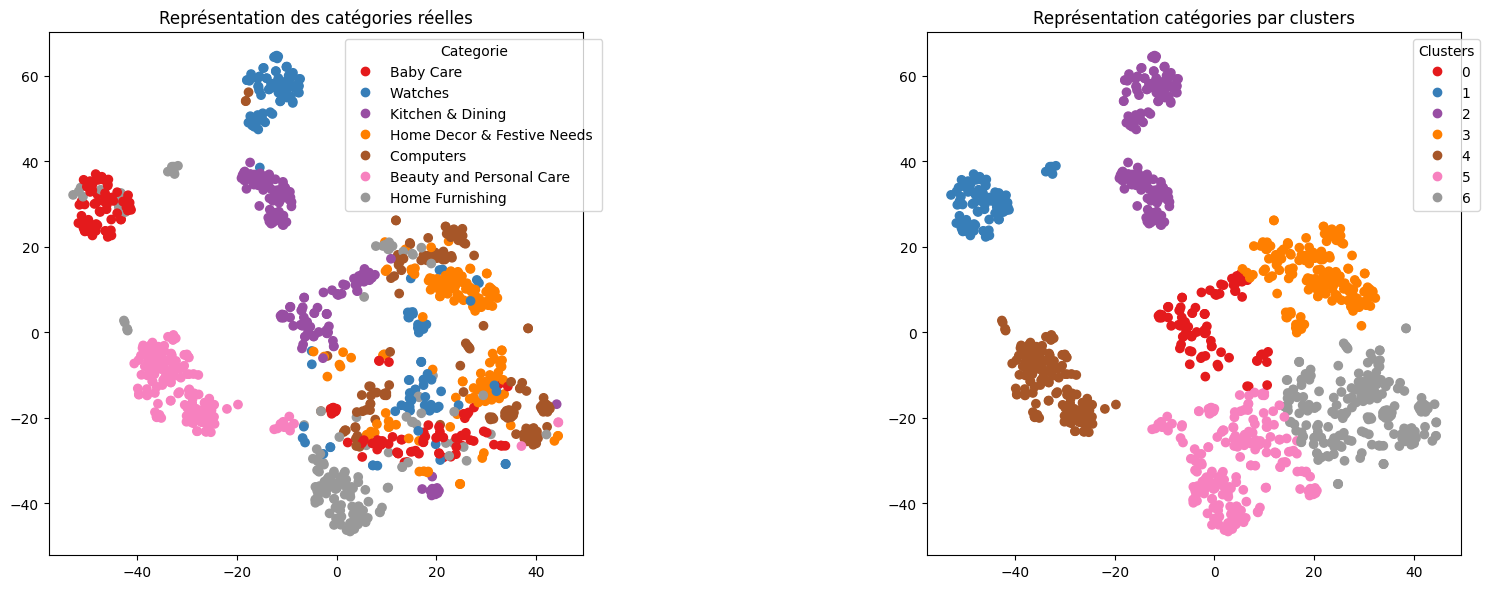

ARI :  0.3203


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [ ]:
import tensorflow_hub as hub
#import tensorflow_text

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
sentences = data_T['sentence_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  242.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3245 time :  13.0


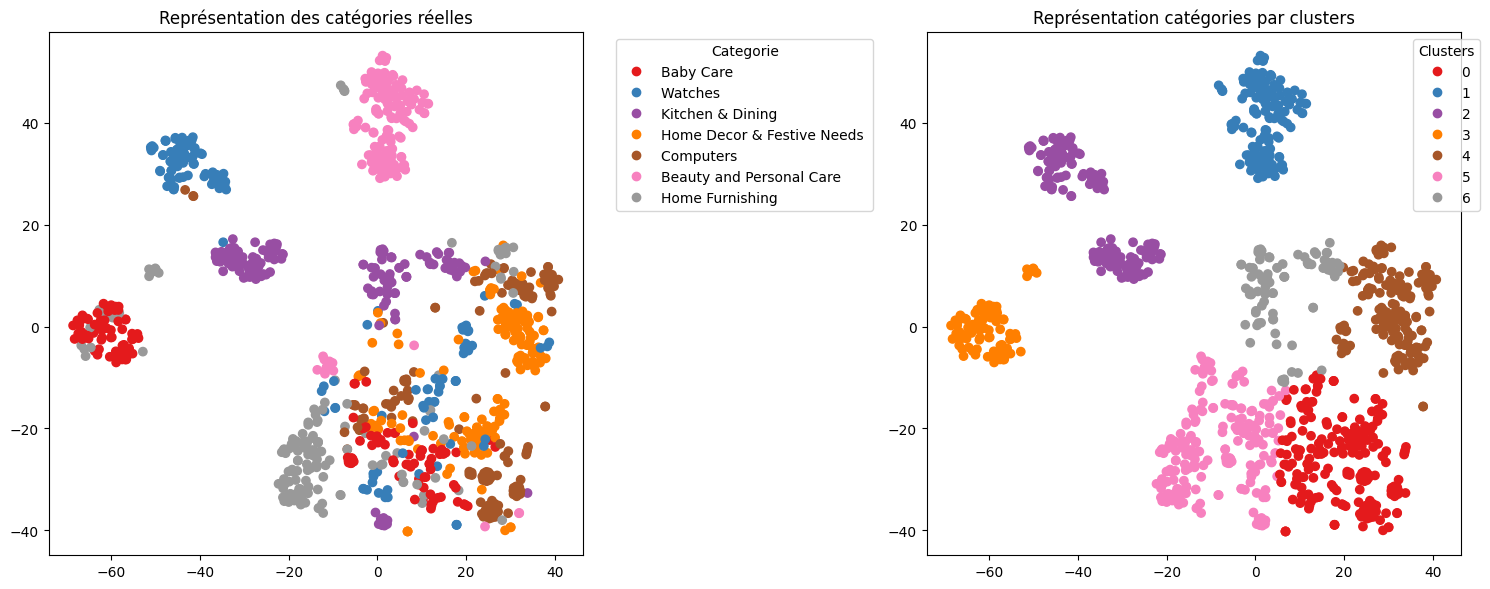

ARI :  0.3245


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
True


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4338 time :  14.0


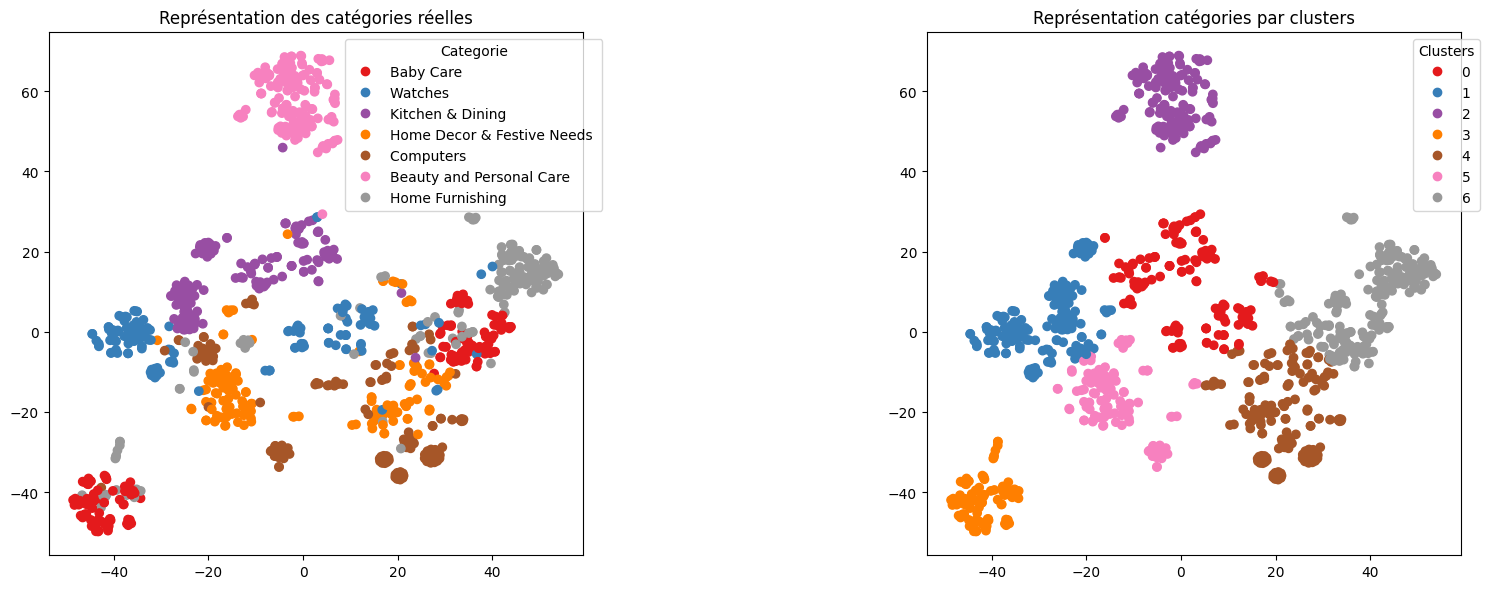

ARI :  0.4338


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)